# System genetics assignment 2

In [1]:
import os
import platform
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Read data sources

In [2]:
# Based on the platform choose the file locations
if platform.system() == 'Windows':
	# Rotem's file paths
	genotype_file_path = os.path.normpath('')
	phenotypes_file_path = os.path.normpath('')
else:
	# Carmi's file paths
	genotype_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/genotypes.xls')
	phenotypes_file_path = os.path.normpath('/Users/Shared/Data/system_genetics_data/phenotypes.xls')
	

genotypes_df = pd.read_excel(genotype_file_path)
chosen_phenotype_df = pd.read_excel(phenotypes_file_path)

In the genotype table, B and D denote parental homozyges individuals and H denotes a heterozygos individual. U are unknows and will therefore be dropped when using their data

Import the Climbing scores after 16 mg/kg i.p. methamphetamine injection [quadrant crossings/min] phenotype from the phenotype table

In [3]:
chosen_phenotype_row = chosen_phenotype_df.loc[chosen_phenotype_df.ID_FOR_CHECK == 172]
# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
chosen_phenotype_row_data_homozygos = chosen_phenotype_row.iloc[:, 7:]

display(chosen_phenotype_row)

,ID_FOR_CHECK,Phenotype,Authors,Year,Pubmed Id,C57BL/6J,DBA/2J,BXD1,BXD2,BXD5,...,BXD94,BXD95,BXD96,BXD97,BXD98,BXD99,BXD100,BXD101,BXD102,BXD103
172,172,Climbing scores after 16 mg/kg i.p. methamphet...,"Grisel JE, Belknap JK, O'Toole LA, Helms ML, W...",1997,8987796.0,2.3,0.6,0.1,-0.8,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Find a locus with hetroziygosity

In [4]:
def get_phenotype_genotype_df(all_snps_df, chosen_phenotype_df, is_include_heterozygos_genotypes=False):
	'''
	Description
	-----------
	Make a dataframe with snps as their original letter, the numaric represantation of them and the phenotype value.
	The function will always drop "U" - unknown genotypes and if is_include_geterozygos_genotypes=True it will incluse hetezygos (H) individuals as well.
	This function does not change the state of the provided dataframes.

	Parameters
	----------
	all_snps_df : pandas dataframe
		The dataframe containing the individuals and thier genotype as a single letter.
		D and B are homozygos parental genotypes, H is geterozygos and U is unknown.
	chosen_phenotype_df : pandas dataframe
		The dataframe containing the individuals and thier phenotype measurement as a float from the chosen phenotype row (only a single row is expected).
	is_include_heterozygos_genotypes : bool
		if set to True, then heterozygos individuals will be included in the returned matrix

	Returns
	-------
	genotype_phenotype_df : pandas dataframe
		Fields:
			individual : str
				The individual BXD id (ex BXD1)
			snp_locus : str,
				The snp locus indentifier (ex rs6269442)
			snp_chr : int,
				the snp chromosome (1, 2...)
			genotype_letter : str,
				B and D denote parental homozyges individuals and H denotes a heterozygos individual
			genotype_num : int,
				The genotype_letter converted to a number, B=0, H=1, D=2
			phenotype_value : float
				The value of the phenotype to associate as a float
	'''
	chosen_phenotype_df_data = chosen_phenotype_df.copy()
	# Remove the first 7 indexes since all the fields between 0 and 4 are metadata and 5 and 6 are mice we do not have in the phenotypes table
	chosen_phenotype_df_data = chosen_phenotype_df_data.iloc[:, 7:]
	# As a first step, remove columns from the phenotypes df that have NaN in them.
	# Since we are expecting a single row then this is OK and won't destroy data for other associations.
	chosen_phenotype_df_data = chosen_phenotype_df_data.dropna(axis=1, how='any')

	# Now remove all genotypes for which we do not have a phenotypic measurement
	snps_df = all_snps_df.copy()
	# Split to data and metadata for ease of work
	snps_df_metadata = snps_df.iloc[:, :4]
	snps_df_data = snps_df.iloc[:, 4:]
	# For some reasson there are 'b' convert them to 'B'
	snps_df_data = snps_df_data.replace('b', 'B')

	# Get the columns to keep
	common_columns = snps_df_data.columns.intersection(chosen_phenotype_df_data.columns)
	snps_df_data = snps_df_data.loc[:, common_columns]
	# Put all the data back into the original dataframe
	snps_df = pd.concat([snps_df_metadata, snps_df_data], axis=1)

	# As the last step of data cleaning set the letters to drop.
	# U is always dropped, and if we aren't keeping heterozygos individuals then remove H as well.
	letters_to_drop = ['U']
	if is_include_heterozygos_genotypes:
		letters_to_drop.append('H')

	snps_df = snps_df.replace(letters_to_drop, pd.NA)

	# Prepare all columns to be saved into a flattened df
	individuals_column = np.tile(snps_df_data.columns, snps_df_data.shape[0])
	locus_column = np.tile(snps_df['Locus'].values.flatten(), snps_df_data.shape[1])
	chr_column = np.tile(snps_df['Chr_Build37'].values.flatten(), snps_df_data.shape[1])
	binary_rep = [ 0 if value == 'B' else (1 if value == 'H' else 2) for value in snps_df_data.values.flatten()]
	phenotypes_column = np.tile(chosen_phenotype_df_data, snps_df_data.shape[0])[0]
	
	
	# Create the final dataframe
	genotype_phenotype_df = pd.DataFrame({
		'individual' : individuals_column,
		'locus' : locus_column,
		'chr' : chr_column,
		'genotype_num' : binary_rep,
		'phenotype_value' : phenotypes_column
	})

	# Since the letter are across many fields it's easier to fill the column this way as opposed to what was done above
	genotype_phenotype_df['genotype_letter'] = genotype_phenotype_df['genotype_num'].apply(lambda x: 'B' if x == 0 else ('H' if x == 1 else 'D'))

	# Move 'phenotype_value' column to the end
	columns = [col for col in genotype_phenotype_df.columns if col != 'phenotype_value'] + ['phenotype_value']
	genotype_phenotype_df = genotype_phenotype_df[columns]


	return genotype_phenotype_df

## Question 1

In [5]:
# Save the locus index found for later use
locus_index = -1

for index, row in genotypes_df.iterrows():
	# Exclude the first three columns (Locus, Chr_Build3, Build37_pc)
	alleles = row[3:]
	if 'B' in alleles.values and 'D' in alleles.values:
		print(f"SNP {row['Locus']} at row {index} has heterozygosity.")
		locus_index = index
		break 

SNP rs6269442 at row 0 has heterozygosity.


In [6]:
chosen_snp = genotypes_df.iloc[index]
chosen_snp_data = chosen_snp.values[4:]

### (a) linear regression model in which heterozygous markers are ignored

The order of operations might need some refactoring. The best way to do this would be to start with dropping the NaNs from the phenotypes then go on from that

First, remove the H and U alleles and save the phenotype individuals associated with them.

In [7]:
# Use to remove the phenotypes that came from a heterozygos individual
indexes_to_drop_from_phenotypes = [i for i, loci in enumerate(chosen_snp) if (loci == 'H' or loci == 'U')]
# Convert the indexes to BXD names so the removal of the phenotypes isn't dependant on the indexes
# as they will change after dropping H and U
individuals_to_drop_from_phenotypes = [chosen_snp.index[i] for i in indexes_to_drop_from_phenotypes]

chosen_snp_no_heterozygose_loci = chosen_snp.replace(['H', 'U'], pd.NA)
chosen_snp_no_heterozygose_loci = chosen_snp_no_heterozygose_loci.dropna()
chosen_snp_no_heterozygose_loci = chosen_snp_no_heterozygose_loci[4:]

print(np.unique(chosen_snp_no_heterozygose_loci))

['B' 'D']


Drop NaN phenotypes and the ones that were associated with the H and U genotypes.

In [8]:
chosen_phenotype_row_data_homozygos = chosen_phenotype_row_data_homozygos.drop(columns=individuals_to_drop_from_phenotypes)
chosen_phenotype_row_data_homozygos = chosen_phenotype_row_data_homozygos.dropna(axis=1, how='any')
display(chosen_phenotype_row_data_homozygos)

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD11,BXD12,BXD13,BXD14,BXD15,...,BXD22,BXD23,BXD24,BXD25,BXD27,BXD28,BXD29,BXD30,BXD31,BXD32
172,0.1,-0.8,1.5,-0.8,0.3,-0.1,0.7,2.6,-1.0,-0.7,...,3.3,0.7,0.8,0.6,0.6,1.0,-1.4,2.6,-0.8,1.6


Go back and remove genotypes that are suitable for this subsection but were associated with a NaN measurement

In [9]:
chosen_snp_no_heterozygose_loci_no_NaN = chosen_snp_no_heterozygose_loci.loc[chosen_phenotype_row_data_homozygos.columns]

Let's see that both data sources are of the correct length and have the correct data in them:

In [10]:
display(chosen_snp_no_heterozygose_loci_no_NaN.shape)
display(chosen_snp_no_heterozygose_loci_no_NaN)

(24,)

BXD1     B
BXD2     B
BXD5     D
BXD6     D
BXD8     D
BXD11    B
BXD12    D
BXD13    B
BXD14    B
BXD15    D
BXD16    D
BXD18    B
BXD19    D
BXD21    D
BXD22    D
BXD23    B
BXD24    B
BXD25    D
BXD27    B
BXD28    D
BXD29    D
BXD30    B
BXD31    B
BXD32    B
Name: 0, dtype: object

In [11]:
display(chosen_phenotype_row_data_homozygos.shape)
display(chosen_phenotype_row_data_homozygos)

(1, 24)

,BXD1,BXD2,BXD5,BXD6,BXD8,BXD11,BXD12,BXD13,BXD14,BXD15,...,BXD22,BXD23,BXD24,BXD25,BXD27,BXD28,BXD29,BXD30,BXD31,BXD32
172,0.1,-0.8,1.5,-0.8,0.3,-0.1,0.7,2.6,-1.0,-0.7,...,3.3,0.7,0.8,0.6,0.6,1.0,-1.4,2.6,-0.8,1.6


As needed, there are only Homozygos indviduals. Now let's do the linear regression as needed

In [12]:
# Convert B to 0 and D to 1
binary_rep = [0 if value == 'B' else 1 for value in chosen_snp_no_heterozygose_loci_no_NaN.values]
genotype_phenotype_df = pd.DataFrame({'genotype_letter' : chosen_snp_no_heterozygose_loci_no_NaN, 'genotype_num': binary_rep, 'phenotype_value': chosen_phenotype_row_data_homozygos.values[0]})
display(genotype_phenotype_df)
print(genotype_phenotype_df.shape)

,genotype_letter,genotype_num,phenotype_value
BXD1,B,0,0.1
BXD2,B,0,-0.8
BXD5,D,1,1.5
BXD6,D,1,-0.8
BXD8,D,1,0.3
BXD11,B,0,-0.1
BXD12,D,1,0.7
BXD13,B,0,2.6
BXD14,B,0,-1.0
BXD15,D,1,-0.7


(24, 3)


In [17]:
genotype_phenotype_df = get_phenotype_genotype_df(genotypes_df, chosen_phenotype_row, is_include_heterozygos_genotypes=True)

display(genotype_phenotype_df.loc[genotype_phenotype_df['locus'] == 'rs6269442'])
print(genotype_phenotype_df.loc[genotype_phenotype_df['locus'] == 'rs6269442'].shape)

,individual,locus,chr,genotype_num,genotype_letter,phenotype_value
0,BXD1,rs6269442,1,0,B,0.1
3796,BXD8,rs6269442,1,0,B,0.3
7592,BXD14,rs6269442,1,2,D,-1.0
11388,BXD19,rs6269442,1,2,D,0.4
15184,BXD24,rs6269442,1,0,B,0.8
18980,BXD29,rs6269442,1,0,B,-1.4
22776,BXD1,rs6269442,1,2,D,0.1
26572,BXD8,rs6269442,1,0,B,0.3
30368,BXD14,rs6269442,1,2,D,-1.0
34164,BXD19,rs6269442,1,2,D,0.4


(24, 6)


In [14]:
# Linear regression implementation goes here

Intercept: 0.5000000000000001
R^2: 0.0011817537225241592
P-values (statsmodels): genotype_num    0.130623
dtype: float64


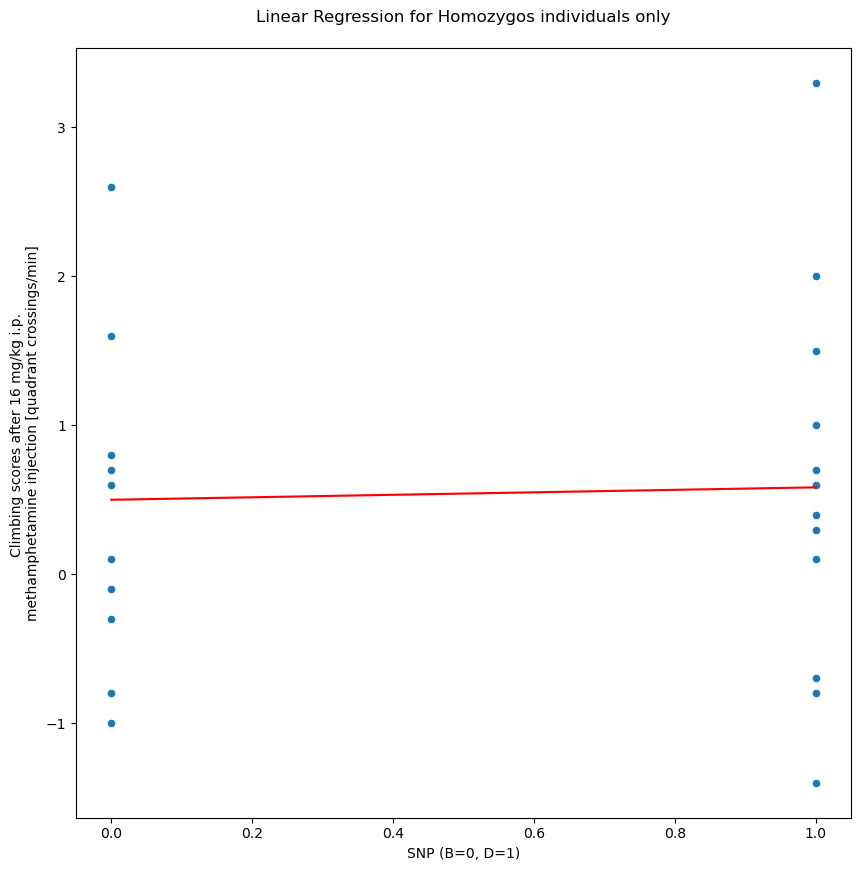

In [15]:
genotype_numbers = genotype_phenotype_df[['genotype_num']]
phenotype_values = genotype_phenotype_df['phenotype_value']

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(genotype_numbers, phenotype_values)
r_sqaured = model.score(genotype_numbers, phenotype_values)

print(f"Intercept: {model.intercept_}")
print(f'R^2: {r_sqaured}')

# Save for plotting
genotype_phenotype_df['Predicted_Trait'] = model.predict(genotype_numbers)

X = sm.add_constant(genotype_numbers)
# Fit the model using statsmodels to get the p-value
model_stats = sm.OLS(phenotype_values, genotype_numbers).fit()
print("P-values (statsmodels):", model_stats.pvalues)

# Plot the data and the regression line
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='genotype_num', y='phenotype_value', data=genotype_phenotype_df)
sns.lineplot(x='genotype_num', y='Predicted_Trait', data=genotype_phenotype_df, color='red')
plt.xlabel('SNP (B=0, D=1)')
plt.ylabel('Climbing scores after 16 mg/kg i.p. \nmethamphetamine injection [quadrant crossings/min]')
plt.title('Linear Regression for Homozygos individuals only\n')
plt.show()